In [1]:
import torch


import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpig
import seaborn as sb

from typing import List,Iterable
import numpy as np 
import os
import random
import math
%matplotlib inline 

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms 
from torch.utils.data import DataLoader

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from torchvision.models import resnet50 
import torch 

from sklearn.metrics import accuracy_score



In [3]:
!pip install torchsummary


[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [4]:
from torchsummary import summary 
from tqdm import tqdm

## TOC 
1. [Utilities](#ch0)
2. [Investigation](#ch1)
- Plotting sample of images
- Distribution of the dataset
- The dimension of the dataset are the same
3. [Custom Data loader](#ch2)
4. [Train on Epoch](#ch3)
- Train on Epoch function 
- Validate on Epoch function 
5. [Prepare loss and Optimizer](#ch4)
6. [Get Resnet50](#ch5)
7. [Start Trainning](#ch6) 
8. [Finale](#finale)

### Utilities <a><a name='ch0'>
  

In [5]:
def nameExteactor(imgName:str)->str: 
    '''
    INPUT: 
    - imagename or img path
    OUTPUT: 
    - STR: Img name 
    
    ACTIONS: 
    given img with name proceed after _ sign itwill extract the name 
    '''
    imgName= imgName.split("/")[-1]
    imgName=imgName.split(".")[0]
    imgName=imgName.split("_")[-1]

    return imgName 
    
    

In [63]:
def verbose_dataset(imgList:List,numOfImgs:int,imgsize,nameExtractorfunc=nameExteactor)-> None:
    '''
    INPUT: 
    - ImgList, list of imagess paths
    - number of imges you want to viualize
    - imgsize tuple to repressent the figure size
    OUTPUT: 
    - None
    
    ACTIONS: 
    will show random number of images as specified from the input 
    bre reading images via cv2 and plotting via matplotlib
    '''
    plt.figure(figsize=imgsize)
    for i in range(numOfImgs): 
        plt.subplot(math.ceil(np.sqrt(numOfImgs)),math.ceil(np.sqrt(numOfImgs))+1,i+1)
        j= random.randint(0,len(imgList))
        img=cv2.imread(imgList[j])
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.title(nameExtractorfunc(imgList[j]))
        plt.axis("off")


In [7]:
def freq(lst:List)-> int:
    """
    INPUT
    - list of classes 
    OUTPUT 
    - returns the distribution of classes 
    
    
    """
    countdict = dict()
    for cls in lst:
        if countdict.get(cls,0):
            countdict[cls] += 1
        else:
            countdict[cls] = 1
    return countdict

In [8]:
def dim_checker(imgpaths:List,ImgSize=None):
    if ImgSize==None: 
        ImgSize= plt.imread(imgpaths[0]).shape
    
    for img in imgpaths: 
        tempImgsize = plt.imread(img).shape
        assert ImgSize==tempImgsize , f"image with path {img} \n has dim {tempImgsize} which is"\
                f'not the same as the rest of the dataset that has dim {ImgSize}'
    print("They are all of the same size",ImgSize)

In [9]:
def getImagesPaths(path:str)->List: 
    '''
    INPUT
    - path to the folder that will have folders inisde each there will be images 
    OUTPUT 
    - Returns list of the full paths of the images  
    '''
    
    imgList=list()
    for direc in os.listdir(path):
        for images in os.listdir(os.path.join(path,direc)):
            # check if the image ends with png or jpg or jpeg
            if (images.endswith(".png") or images.endswith(".jpg")\
                or images.endswith(".jpeg")):
            # display
                imgList.append(os.path.join(path,direc,images))
    return imgList 

In [101]:
def verbose_model(model,transforms,device,namesDict,imgList:List,numOfImgs:int,imgsize,nameExtractorfunc=nameExteactor)-> None:
    '''
    INPUT: 
    - ImgList, list of imagess paths
    - number of imges you want to viualize
    - imgsize tuple to repressent the figure size
    OUTPUT: 
    - None
    
    ACTIONS: 
    will show random number of images as specified from the input 
    bre reading images via cv2 and plotting via matplotlib
    '''
    plt.figure(figsize=imgsize)
    for i in range(numOfImgs): 
        plt.subplot(math.ceil(np.sqrt(numOfImgs)),math.ceil(np.sqrt(numOfImgs))+1,i+1)
        j= random.randint(0,len(imgList))
        img=cv2.imread(imgList[j])
        
        data= transforms(img)
        data = data.unsqueeze(0) 
        transformedImg= data.to(device)
        
        model.to(device)
        outputs = model(transformedImg)
        outputs = outputs.detach().cpu().numpy()
        predicted= np.argmax(outputs, axis=1)[0]
        
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.title(f"real {namesDict[nameExtractorfunc(imgList[j])]} \n predicted: {predicted}" )
        plt.axis("off")

### Investigsting dataset <a><a name='ch1'>
- [plotting samples from the iamge](#sec1.0) 

- [Images class distribution](#sec1.1) 

- [The dimensions of all the images](#sec1.2) 

In [10]:
list(os.listdir())

['EgyptianHieroglyphDataset.zip',
 'w',
 'home',
 '.ipynb_checkpoints',
 'GlyphDataset',
 'EgyptianHieroglyphDataset',
 'Inference .ipynb',
 'papers',
 'Ramses_An_annotated_Corpus_of_Late_Egypt',
 'Ramses_An_annotated_Corpus_of_Late_Egypt.zip',
 'GlyphDataset.zip',
 'copiedversion.ipynb']

In [11]:
path=os.getcwd()
path=os.path.join(path,"EgyptianHieroglyphDataset","EgyptianHieroglyphDataset_134","train")
imgList=list()
for direc in os.listdir(path):
    for images in os.listdir(os.path.join(path,direc)):
        # check if the image ends with png or jpg or jpeg
        if (images.endswith(".png") or images.endswith(".jpg")\
            or images.endswith(".jpeg")):
            # display
            imgList.append(os.path.join(path,direc,images))

In [12]:
print(len(imgList))
#print(imgList[j])
print(path)

3141
/home/ahmed/Datasets/Hieroglyph/EgyptianHieroglyphDataset/EgyptianHieroglyphDataset_134/train


<a><a name='sec1.0'>

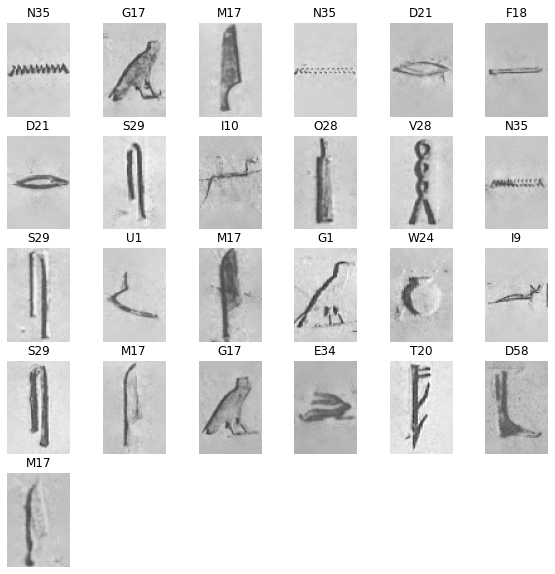

In [13]:
verbose_dataset(imgList,25,(10,10))

Image class distribtuion <a><a name='sec1.1'>


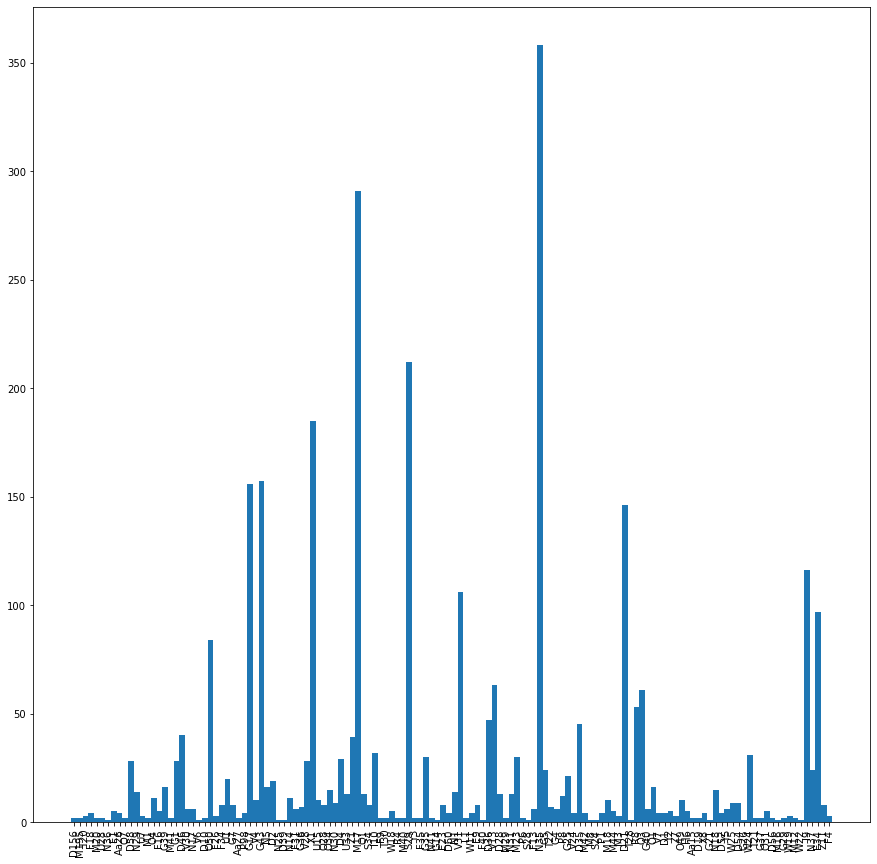

In [14]:
imgClasses= list(map(nameExteactor,imgList))
plt.figure(figsize=(15,15))
images= freq(imgClasses)
plt.bar(images.keys(),images.values(),width=1);
plt.xticks(rotation=90);

Dimension of all images <a><a name='sec1.2'>

In [15]:
dim_checker(imgList)

They are all of the same size (75, 50)


### Border detection <a><a name='intermediate'>


In [16]:
img=cv2.imread(imgList[0])
img.shape

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blured= cv2.GaussianBlur(gray, (3,3), 1)
ret,thresh = cv2.threshold(blured,0,255,cv2.THRESH_OTSU)
kernel= cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
contours,hire= cv2.findContours(img_dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
sortedCountours= sorted(contours, key = lambda ctr: cv2.boundingRect(ctr)[0])

0 0 50 75
14 10 12 58


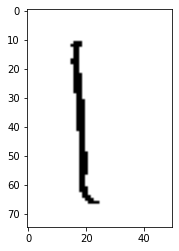

In [17]:
plt.imshow(img_dilation,'gray')
for cnt in sortedCountours: 
    x,y,w,h= cv2.boundingRect(cnt)
    print(x,y,w,h)
    continue
    plt.imshow(cv2.rectangle(img_dilation,(x,y),(x+w,y+h),(0,0,255),2))

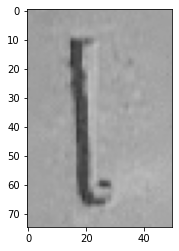

In [18]:
plt.imshow(img)
    

### Custom data loader <a><a name='ch2'>

In [19]:
def dataPreparations():
    '''
    I will use this function as an augmentation one later on 
    '''
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                         transforms.RandomRotation(degrees=(-10, 10)),
                                         transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                         transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                        contrast=(1, 1.5),
                                                                                        saturation=(1, 1.5),
                                                                                        hue=(0, 0.5))]),
                                         transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                  inplace=False),
                                         transforms.Normalize((0.5,), (0.5,))])
    pass


In [20]:
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers, shuffle=True)

In [21]:
data_transform= transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))])
dataset= ImageFolder(path,transform=data_transform)
dataloader= DataLoader(dataset,batch_size=20,pin_memory=True,shuffle=True, num_workers=8)

/home/ahmed/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
def getDataLoader(path:str,transforms,batchsize,num_workers=8,pinmemory=True,shuffle=True)->Iterable:
    dataset= ImageFolder(path,transform=data_transform)
    dataloader= DataLoader(dataset,
                           batch_size=batchsize,
                           pin_memory=pinmemory,
                           shuffle=shuffle,
                           num_workers=num_workers)
    return dataloader

In [23]:
dataset.class_to_idx

{'Aa15': 0,
 'Aa26': 1,
 'Aa27': 2,
 'D1': 3,
 'D10': 4,
 'D156': 5,
 'D19': 6,
 'D2': 7,
 'D21': 8,
 'D28': 9,
 'D35': 10,
 'D36': 11,
 'D39': 12,
 'D4': 13,
 'D46': 14,
 'D52': 15,
 'D54': 16,
 'D56': 17,
 'D58': 18,
 'D60': 19,
 'E1': 20,
 'E23': 21,
 'E34': 22,
 'E9': 23,
 'F13': 24,
 'F16': 25,
 'F18': 26,
 'F26': 27,
 'F31': 28,
 'F34': 29,
 'F35': 30,
 'F4': 31,
 'F40': 32,
 'F9': 33,
 'G1': 34,
 'G14': 35,
 'G17': 36,
 'G21': 37,
 'G25': 38,
 'G26': 39,
 'G29': 40,
 'G35': 41,
 'G36': 42,
 'G37': 43,
 'G39': 44,
 'G4': 45,
 'G40': 46,
 'G43': 47,
 'G5': 48,
 'G7': 49,
 'H6': 50,
 'I10': 51,
 'I9': 52,
 'L1': 53,
 'M1': 54,
 'M12': 55,
 'M16': 56,
 'M17': 57,
 'M18': 58,
 'M195': 59,
 'M20': 60,
 'M23': 61,
 'M29': 62,
 'M3': 63,
 'M40': 64,
 'M41': 65,
 'M42': 66,
 'M44': 67,
 'M8': 68,
 'N1': 69,
 'N14': 70,
 'N17': 71,
 'N18': 72,
 'N25': 73,
 'N29': 74,
 'N30': 75,
 'N31': 76,
 'N35': 77,
 'N36': 78,
 'N37': 79,
 'N41': 80,
 'N5': 81,
 'O1': 82,
 'O28': 83,
 'O31': 84,
 'O34

### Train on batch <a><a name='ch3'>

In [24]:
def trainOnEpoch(dataloader,model,criterion,optimizer,device,epochNum=1):
    # x,y,model to cuda 
    # make forward
    # calculate loss 
    # optimizer step 
    # zero grad 
    # empty cahce
    avgLoss=0.0
    model.train()

    with tqdm(dataloader, unit="batch") as tepoch:
        for x,y in tepoch:
            tepoch.set_description(f"Epoch {epochNum}")
            model.zero_grad()

            x= x.to(device)
            y= y.to(device)
            model.to(device)


            outputs= model(x)
            loss = criterion(outputs, y)

            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            avgLoss+= loss.item()
            torch.cuda.empty_cache()
            del x 
            del y

    
    avgLoss= np.mean(avgLoss)
    
    
    
    
    return avgLoss

In [41]:
def testOnEpoch(testloader,model,criterion,device,accuracyfunc=accuracy_score):

    avgLoss=0.0
    model.eval()
    predictions=[]
    actuals=[]
    with torch.no_grad():

        for _,(x,y) in enumerate(testloader): 


            x= x.to(device)
            y= y.to(device)
            model.to(device)


            outputs= model(x)
            loss = criterion(outputs, y)
            avgLoss+= loss.item()
            
            outputs = outputs.cpu().numpy()
            targets = y.cpu().numpy()
            
            outputs = np.argmax(outputs, axis=1)
            
            # reshape for stacking
            targets = targets.reshape((len(targets), 1))
            outputs = outputs.reshape((len(outputs), 1))

            actuals.append(targets)
            predictions.append(outputs)
            
            

    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    acc = accuracyfunc(actuals, predictions) * 100
    avgLoss= np.mean(avgLoss)
    torch.cuda.empty_cache()

    return avgLoss,acc

### Get Resnet50 <a><a name="ch5">

In [26]:
resnet50(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
model = resnet50(pretrained=True)

In [28]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [29]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [30]:
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 134)

In [31]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

### Loss and Optimizer <a><a name="ch4">

In [32]:
loss= CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

### Start Trainning <a><a name='ch6'> 

In [33]:
path=os.getcwd()
trainPath=os.path.join(path,"EgyptianHieroglyphDataset","EgyptianHieroglyphDataset_134","train")
testPath=os.path.join(path,"EgyptianHieroglyphDataset","EgyptianHieroglyphDataset_134","test")

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,)), 
                                     transforms.Resize((224,224))])

In [35]:
summary(model.to('cuda'),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [36]:
batchsize=64

trainloader= getDataLoader(trainPath,
                           transforms,
                           batchsize,
                           num_workers=0,
                           pinmemory=True,
                           shuffle=True)

testloader= getDataLoader(testPath,
                           transforms,
                           batchsize,
                           num_workers=0,
                           pinmemory=True,
                           shuffle=True)


In [37]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
PATH=r"/home/ahmed"

In [ ]:
numEpochs = 25
trainloss=[]
validationLosses= []

model.to(device)
loss= CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.99)

max_accuracy= 75.50
for epoch in range(15,25): 
    tloss= trainOnEpoch(trainloader,model,loss,optimizer,device,epoch+1)
    vloss,vaccuracy=testOnEpoch(testloader,model,loss,device)
    
    trainloss.append(tloss)
    validationLosses.append(vloss)
    
    print(f"Epoch num {epoch}: Trainning loss : {tloss:0.2f}  Vlidation Loss {vloss:0.2f}"\
          f"Valdation accuracy {vaccuracy:0.2f}")
    if vaccuracy > max_accuracy:
        max_accuracy = vaccuracy
        torch.save(model.state_dict(),"w/model.pth")
       
    

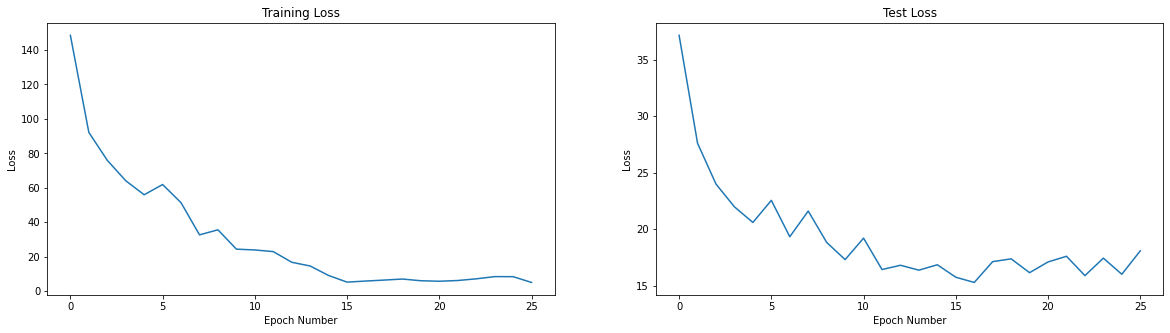

In [74]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1);
plt.title('Training Loss');
plt.xlabel('Epoch Number');
plt.ylabel('Loss');
plt.plot(trainloss);

plt.subplot(1,2,2);
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(validationLosses);




### Inference <a><a name='finale'>

In [40]:
model = resnet50()
model.fc = torch.nn.Linear(2048, 134)
model.load_state_dict(torch.load("w/model.pth"))

<All keys matched successfully>

In [55]:
from sklearn.metrics import confusion_matrix
avglos,acc= testOnEpoch(testloader,model,loss,'cuda')

In [56]:
img=cv2.imread(imgList[0])


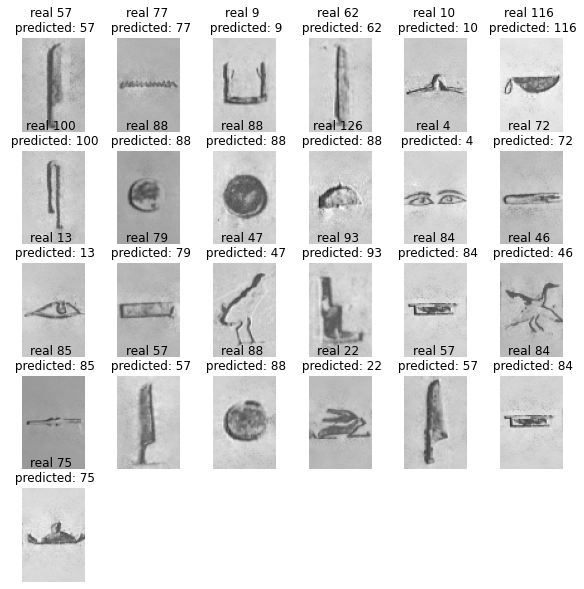

In [102]:
verbose_model(model,data_transform,"cuda",dataset.class_to_idx,imgList,25,(10,10))

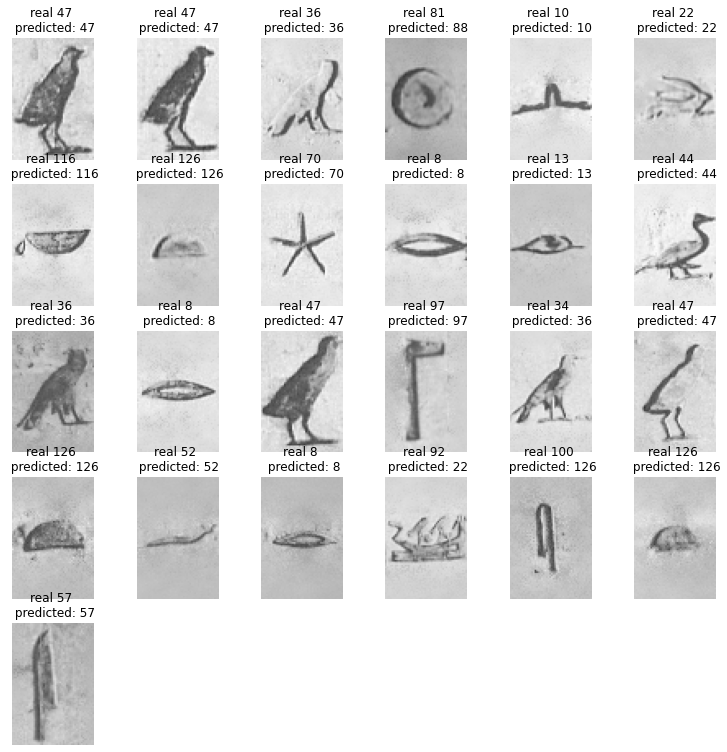

In [104]:
testimgList= getImagesPaths(testPath)
verbose_model(model,data_transform,"cuda",dataset.class_to_idx,testimgList,25,(13,13))